In [1]:
import tensorflow as tf
import numpy as np
import inceptionv3
from utils import *
from defense import *

In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole

# Classifier

In [4]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from data/inception_v3.ckpt


In [5]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

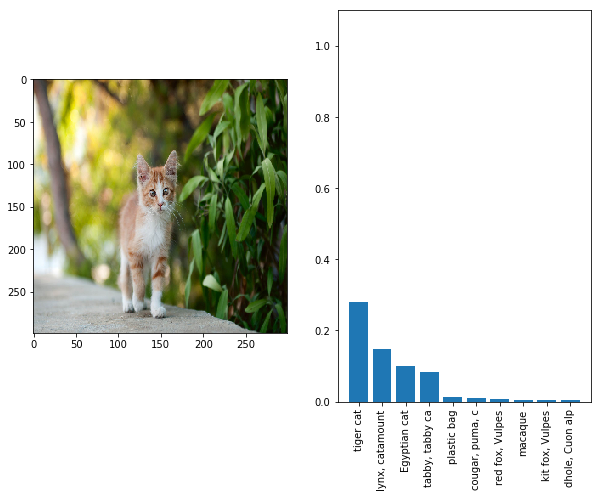

In [6]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [7]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [8]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=282
step 1, l2=0.000056, pred=277
step 2, l2=0.000075, pred=231
step 3, l2=0.000095, pred=263
step 4, l2=0.000102, pred=274
step 5, l2=0.000113, pred=282
step 6, l2=0.000123, pred=924
step 7, l2=0.000139, pred=924
step 8, l2=0.000151, pred=924
step 9, l2=0.000162, pred=924


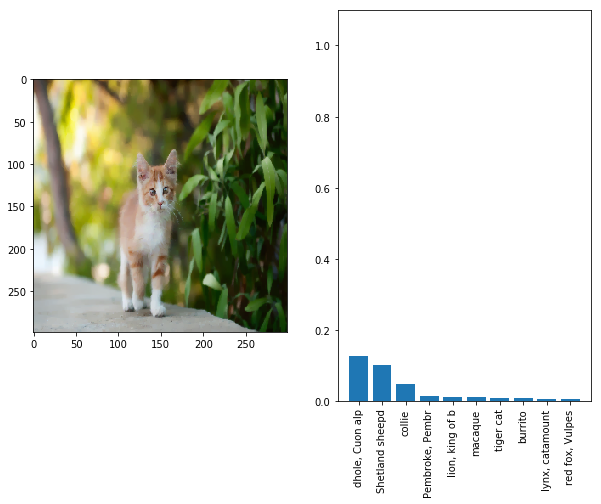

In [9]:
classify(defend_tv(adv), target_class=TARGET)

# Attack

Using BPDA.

In [10]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    adv_def = defend_tv(adv)
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv_def, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=285
step 1, l2=0.000027, pred=263
step 2, l2=0.000051, pred=157
step 3, l2=0.000090, pred=263
step 4, l2=0.000145, pred=924
step 5, l2=0.000197, pred=924
step 6, l2=0.000206, pred=924
step 7, l2=0.000207, pred=924
step 8, l2=0.000208, pred=924
step 9, l2=0.000209, pred=924


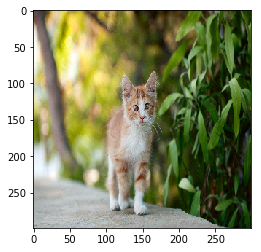

In [11]:
plt.imshow(adv)

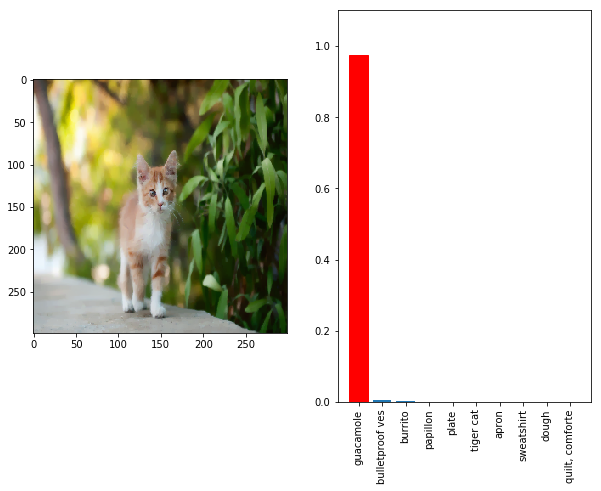

In [12]:
classify(defend_tv(adv), target_class=TARGET)